In [3]:
import sys
sys.path.append("../scikit-learn")

**<u>Question 1<u/>**<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Pour des données linéairement séparables, le paramètre C n'influence pas du tout le résultat dans le cas d'un noyau linéaire, résultat sans erreur par ailleurs d'après la construction du modèle. Dans le cas d'un noyau gaussien, il n'y a pas non plus d'erreur même si la frontière est moins "naturelle". Pour des données unimodales séparables, on a le même résultat, et le noyau gaussien s'adapte bien à un nuage gaussien de points. Lorsque les données sont non séparables le paramètre C influence légèrement l'orientation de l'hyperplan séparateur dans le cas linéaire (le taux de reconnaissance reste assez élevé), dans le cas gaussien la frontière est susceptible de changer assez fortement. Dans le cas gaussien, le paramètre gamma a un très gros effet sur la frontière : lorsque gamma est mal choisi, on a soit un modèle avec énormément d'erreur qui est beaucoup trop "simple" (quand gamma trop petit), soit un modèle beaucoup trop précis avec une frontière formée autour de quelques ilôts minuscules (quand gamma trop grand).

**<u>Question 2<u/>**<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Les 3 zones d'intérêt sont : à l'extérieur du support, du côté où la classe du point est majoritaire (A), à l'intérieur de la marge (B), et à l'extérieur du support, de "l'autre côté" (C). Lorsqu'on ajoute un point dans la zone A, il ne se passe rien : la frontière reste identique ($\alpha_i=0$). Lorsqu'on ajoute un point dans la zone B, la marge change et le point devient un support, $\alpha_i\neq0$. Lorsqu'on ajoute un point dans la zone C, la marge change également, le point devient aussi un support, $\alpha_i\neq0$.

**<u>Question 3<u/>**<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lorsqu'on déséquilibre fortement les données et que C devient trop petit, la frontière devient incorrecte car les points en minorité sont inclus dans la zone de décision des points de classe majoritaire. Cela est du au fait que l'attache au données devient trop faible et que le terme $||w||^2$ l'emporte dans la minimisation : la direction de la frontière reste la même mais l'offset change, ce qui rend la frontière mauvaise.

In [4]:
import matplotlib.pyplot as plt
import utils
import numpy as np
%matplotlib inline

Mean score for c = 1 : 0.78


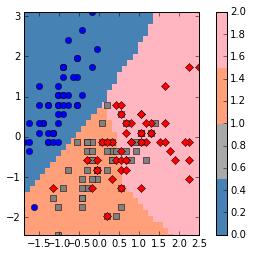

In [5]:
from sklearn.cross_validation import cross_val_score
from sklearn.utils import shuffle
from sklearn import datasets
from sklearn import svm

iris = datasets.load_iris()
X, y = shuffle(iris.data[:,:2], iris.target, random_state=0)
mean, std = X.mean(axis=0), X.std(axis=0)
X = (X - mean) / std
X[np.isnan(X)] = 0

clf = svm.SVC()
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=5)
print("Mean score for c = 1 : "+str(scores.mean()))
utils.plot_2d(X,y)
utils.frontiere(clf.predict,X)

In [6]:
X2 = X[:len(X)//2,:]
y2 = y[:len(y)//2]
X3 = X[len(X)//2:,:]
y3 = y[len(y)//2:]

C = 0.000015
M = 0
for c in range(11):
    clf = svm.SVC(C=C)
    clf.fit(X2, y2)
    scores = cross_val_score(clf, X2, y2, cv=5)
    m = scores.mean()
    print("Mean score for C = "+str(C)+" : "+str(m))
    if m>M:
        M = m
        c_final = C
    C = C*10

print("Max score reached in linear kernel for C="+str(c_final))
print('')

m = 0
for d in range(1,10):
    clf = svm.SVC(degree=d,kernel='poly')
    clf.fit(X2, y2)
    scores = cross_val_score(clf, X2, y2, cv=5)
    m = scores.mean()
    print("Mean score for polynomial kernel d = "+str(d)+" : "+str(m))
    if m>M:
        M = m
        d_final = d

print("Max score reached in polynomial kernel for d="+str(d_final))

Mean score for C = 1.5e-05 : 0.400714285714
Mean score for C = 0.00015 : 0.400714285714
Mean score for C = 0.0015 : 0.400714285714
Mean score for C = 0.015 : 0.400714285714
Mean score for C = 0.15 : 0.680357142857
Mean score for C = 1.5 : 0.737261904762
Mean score for C = 15.0 : 0.697261904762
Mean score for C = 150.0 : 0.670476190476
Mean score for C = 1500.0 : 0.60369047619
Mean score for C = 15000.0 : 0.641904761905
Mean score for C = 150000.0 : 0.617857142857
Max score reached in linear kernel for C=1.5

Mean score for polynomial kernel d = 1 : 0.74880952381
Mean score for polynomial kernel d = 2 : 0.549404761905
Mean score for polynomial kernel d = 3 : 0.655238095238
Mean score for polynomial kernel d = 4 : 0.547619047619
Mean score for polynomial kernel d = 5 : 0.641071428571
Mean score for polynomial kernel d = 6 : 0.534285714286
Mean score for polynomial kernel d = 7 : 0.614404761905
Mean score for polynomial kernel d = 8 : 0.520952380952
Mean score for polynomial kernel d = 9 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV


##############################################################################
# Load and prepare data set
#
# dataset for grid search

iris = load_iris()
X = iris.data
y = iris.target

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

##############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(start=0, stop=12, base=2)
gamma_range = np.logspace(start=-8, stop=4, base=2)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

##############################################################################
# visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
# We extract just the scores
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=1, bottom=0.15, top=1)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()